In [ ]:
import torch
import torch.nn.functional as F

# Example signal, use your actual signal here
x = torch.tensor([[-0.5414,  0.1313,  0.1726,  0.1465,  0.1295,  0.0562,  0.0679,  0.1480,
         0.1408,  0.1036,  0.1538,  0.2541,  0.3546,  0.3808,  0.3487,  0.3513,
         0.3651,  0.2935,  0.2285,  0.2205,  0.1898,  0.2323,  0.1738,  0.0534,
         0.1308,  0.1913,  0.2050,  0.2081,  0.1776,  0.1818,  0.0410, -0.1567,
        -0.3132, -0.4532, -0.3681, -0.2606, -0.3623, -0.4558, -0.4615, -0.4234,
        -0.3493, -0.3153, -0.2787, -0.1456, -0.0436,  0.0054,  0.0263,  0.0383,
         0.1893,  0.1918]])

# Use just the first 10 values
signal = x[0]  # The 1D signal you're working with

# Normalize the signal (optional, depending on your data)
min_val = signal.min()
max_val = signal.max()
normalized_signal = (signal - min_val) / (max_val - min_val)

# Calculate the histogram (probability distribution)
hist = torch.histc(normalized_signal, bins=256, min=0.0, max=1.0)
prob_dist = hist / hist.sum()  # Normalize to get probabilities

# Shannon entropy
entropy = -torch.sum(prob_dist * torch.log(prob_dist + 1e-6))  # Adding a small epsilon to avoid log(0)

print(f"Shannon Entropy: {entropy.item()}")


In [16]:
import numpy as np
import torch
import torch.nn as nn
from scipy.signal import spectrogram

In [ ]:
x = torch.randn(32, 1, 600)


_, _, Sxx = spectrogram(
    x.detach().cpu().numpy().astype(np.double),
    fs=100,
    window="hamming",
    nperseg=200,
    noverlap=100,
    nfft=256,
)

Sxx = Sxx[:,:, :128]
# log_10 scale the spectrogram safely (using epsilon)
Sxx = 20 * np.log10(np.abs(Sxx) + np.finfo(float).eps)
Sxx = torch.tensor(Sxx, dtype=torch.float32, device=x.device)
Sxx = Sxx.permute(0,1,3,2)
print(Sxx.shape)




In [12]:
residual_layer = nn.Sequential(
    nn.Conv2d( 1, 8, 5, 1, 2),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    nn.Conv2d( 8, 16, 5, 1, 2),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d( 16, 1, 5, 1, 2),
    nn.ReLU(),
)

In [ ]:
residual_layer(Sxx).shape

---

In [5]:
from collections import OrderedDict
import torch
import torch.nn as nn

In [ ]:
hidden_size = 500
test = torch.randn(10, 1,  hidden_size)
print(test.shape)
num_segments = 3000 // hidden_size
print(num_segments)

In [29]:
conv1 = nn.Sequential( OrderedDict([
    ("conv1", nn.Conv1d(1, 32, 4)),
    ("relu1", nn.ReLU()),
    ("maxpool1", nn.MaxPool1d(4)),
    ("batchnorm1", nn.BatchNorm1d(32)),
    ("conv2", nn.Conv1d(32, 64, 4)),
    ("relu2", nn.ReLU()),
    ("maxpool2", nn.MaxPool1d(hidden_size // 100)),
    ("batchnorm2", nn.BatchNorm1d(64)),
    ("conv3", nn.Conv1d(64, 128, 4)),
    ("relu3", nn.ReLU()),
    ("maxpool3", nn.MaxPool1d(4)),
    ("batchnorm3", nn.BatchNorm1d(128)),
    ("conv4", nn.Conv1d(128, 256, 5)),
    ("flatten", nn.Flatten()),
]))

In [ ]:
for hidden_size in [200, 300, 500, 600]:  
    print(f"hidden_size: {hidden_size}")
    conv1 = nn.Sequential( OrderedDict([
        ("conv1", nn.Conv1d(1, 32, 4)),
        ("relu1", nn.ReLU()),
        ("maxpool1", nn.MaxPool1d(4)),
        ("batchnorm1", nn.BatchNorm1d(32)),
        ("conv2", nn.Conv1d(32, 64, 4)),
        ("relu2", nn.ReLU()),
        ("maxpool2", nn.MaxPool1d(hidden_size // 100)),
        ("batchnorm2", nn.BatchNorm1d(64)),
        ("conv3", nn.Conv1d(64, 128, 4)),
        ("relu3", nn.ReLU()),
        ("maxpool3", nn.MaxPool1d(4)),
        ("batchnorm3", nn.BatchNorm1d(128)),
        ("conv4", nn.Conv1d(128, 256, 5)),
        ("flatten", nn.Flatten()),
    ]))
    out_size = conv1(torch.randn(1, 1,  hidden_size)).shape
    print(out_size)

In [ ]:
x= test
print("Input shape:", x.shape)
for i, layer in enumerate(conv1):
    x = layer(x)
    print(f"Output shape dopo il layer {i} ({layer.__class__.__name__}): {x.shape}")

---

In [6]:
from typing import List, Callable
from physioex.data import PhysioExDataset
from physioex.data.datamodule import PhysioExDataModule
from physioex.train.networks import config as network_config
from physioex.train.bin.parser import deep_update
import importlib
import numpy as np

from physioex.train.utils.train import train

In [7]:
class EmanueleDataset( PhysioExDataset ):
    def __init__(
        self,
        datasets: List[str],
        data_folder: str,
        preprocessing: str = "raw",
        selected_channels: List[int] = ["EEG"],
        sequence_length: int = 21,
        target_transform: Callable = None,
        hpc: bool = False,
        indexed_channels: List[int] = ["EEG", "EOG", "EMG", "ECG"],
        task: str = "sleep",
    ):
        super().__init__(
            datasets = datasets,
            data_folder = data_folder,
            preprocessing = preprocessing,
            selected_channels = selected_channels,
            sequence_length = sequence_length,
            target_transform = target_transform,
            hpc = hpc,
            indexed_channels = indexed_channels,
            task = task,
        )

        self.emanuele_data = PhysioExDataset(
            datasets = datasets,
            data_folder = data_folder,
            preprocessing = "emanuele",
            selected_channels = selected_channels,
            sequence_length = sequence_length,
            target_transform = target_transform,
            hpc = hpc,
            indexed_channels = indexed_channels,
            task = task,
        )
        return

    def __getitem__(self, idx):
        X, _ = super().__getitem__(idx)
        #print("X shape:", X.shape)
        #print("self.L:", self.L)
        X = X.reshape( self.L, len(self.channels_index), 5, 600)
        y, _ = self.emanuele_data.__getitem__(idx)      
        #print("X shape:", X.shape)
        #print("y shape:", y.shape)  
        
        X = X.permute(0, 2, 1, 3)
        y = y.permute(0, 2, 1, 3, 4)
        
        X = X.reshape( self.L*5, len(self.channels_index), 600)
        y = y.reshape( self.L*5, len(self.channels_index), 5, 129)
        
        return X, y

In [8]:
emanuele_data = EmanueleDataset(
    datasets = ["mass"],
    data_folder = "/mnt/guido-data/",
    preprocessing = "raw",
    selected_channels = ["EEG", "EOG", "EMG"],
    sequence_length = 21,
    indexed_channels = ["EEG", "EOG", "EMG"],
)
signal, labels = emanuele_data.emanuele_data[0]
print(signal.shape, labels.shape)
signal = np.transpose(signal, (0, 2, 1, 3, 4)).reshape( -1, 3, 5, 129)
print(signal.shape, labels.shape)

torch.Size([21, 3, 5, 5, 129]) torch.Size([21])
torch.Size([105, 3, 5, 129]) torch.Size([21])


In [9]:
datamodule = PhysioExDataModule(
    datasets = emanuele_data,
    batch_size = 32,
)
print( datamodule.dataset.emanuele_data )
print( datamodule.dataset)
signal, label = datamodule.dataset.emanuele_data[0]
print(signal.shape, label.shape)


torch.Size([21, 3, 5, 5, 129]) torch.Size([21])


In [10]:
default_config = network_config["default"].copy()
config = network_config["protosleepnet_reconstructor_mass"]

deep_update(default_config, config)
config = default_config

config["model_kwargs"]["in_channels"] = 3
config["model_kwargs"]["sequence_length"] = 21

module, class_name = config["model"].split(":")
config["model"] = getattr(importlib.import_module(module), class_name)

In [11]:
print(datamodule.dataset)

In [ ]:
train(
    datasets = datamodule,
    model_class = config["model"],
    model_config = config["model_kwargs"],
    model = None,
    monitor = "val_loss",
)

In [12]:
from scipy.signal import welch
import seaborn as sns
import torch

In [17]:
def welch_psd(x, fs=1.0, nperseg=256, noverlap=None, nfft=None):
    if noverlap is None:
        noverlap = nperseg // 2
    if nfft is None:
        nfft = nperseg

    batch_size, signal_len = x.size()   #x shape: [-1, 600]

    # Window function
    window = torch.hann_window(nperseg, periodic=False).to(x.device)

    # Calculate the number of segments
    step = nperseg - noverlap
    shape = (batch_size, (x.size(1) - noverlap) // step, nperseg)   #shape shape: [-1, 11, 100]
    strides = (x.stride(0), x.stride(1) * step, x.stride(1))    #strides shape: [600, 50, 1]
    segments = torch.as_strided(x, size=shape, stride=strides)  #segments shape: [-1, 11, 100]

    # Apply window to each segment
    segments = segments * window

    # Compute FFT and power spectral density
    fft_segments = torch.fft.fft(segments, n=nfft)
    #print("fft_all: ", fft_segments.shape) 
    fft_segments = fft_segments[..., : nfft // 2 + 1]
    #print("fft_pos: ", fft_segments.shape) 
    psdx = (1 / (fs * nfft)) * torch.abs(fft_segments)**2
    psdx[..., 1:-1] = 2 * psdx[..., 1:-1]
    #print(psdx.shape) #[3,11]

    #psd = (fft_segments.abs() ** 2) / (fs * nperseg)

    # Average over segments
    psd = psdx.mean(dim=1)   #psd shape: [-1, 129]

    # Frequency axis
    freqs = torch.fft.rfftfreq(nfft, 1 / fs)

    return freqs, psd

In [16]:
import torch

def welch_psd(x, fs=1.0, nperseg=256, noverlap=None, nfft=None):
    if noverlap is None:
        noverlap = nperseg // 2
    if nfft is None:
        nfft = nperseg

    batch_size, signal_len = x.size()

    # Window function
    window = torch.hann_window(nperseg, periodic=False).to(x.device)
    # Calculate the number of segments
    step = nperseg - noverlap
    shape = (batch_size, (x.size(1) - noverlap) // step, nperseg)   #shape shape: [-1, 11, 100]
    strides = (x.stride(0), x.stride(1) * step, x.stride(1))    #strides shape: [600, 50, 1]
    segments = torch.as_strided(x, size=shape, stride=strides)  #segments shape: [-1, 11, 100]

    # Apply window to each segment
    segments = segments * window

    # Compute FFT and power spectral density
    fft_segments = torch.fft.rfft(segments, n=nfft)
    psdx = (1 / (fs * nfft)) * torch.abs(fft_segments)**2
    psdx[..., 1:-1] *= 2  # Double the power except for the DC and Nyquist components

    # Average over segments
    psd = psdx.mean(dim=1)

    # Frequency axis
    freqs = torch.fft.rfftfreq(nfft, 1 / fs).to(x.device)

    return freqs, psd

In [14]:
emanuele_data = EmanueleDataset(
    datasets = ["mass"],
    data_folder = "/mnt/guido-data/",
    preprocessing = "raw",
    selected_channels = ["EEG", "EOG", "EMG"],
    sequence_length = 21,
    indexed_channels = ["EEG", "EOG", "EMG"],
)
signal, labels = emanuele_data[0]
signal.shape

torch.Size([105, 3, 600])

torch.Size([3, 129]) torch.Size([129])


<Axes: >

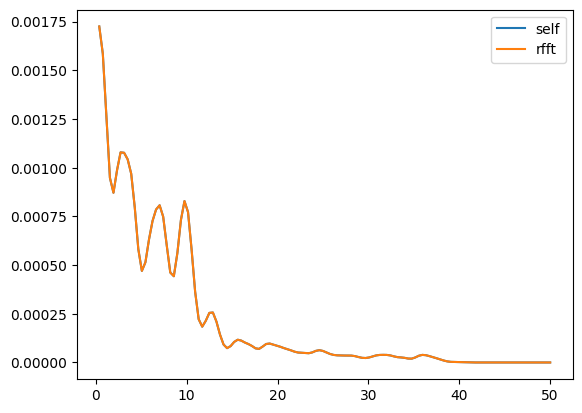

In [21]:
freq_x, welch_x = welch_psd(signal[0], fs=100, nperseg=100, noverlap=50, nfft=256)
scipy_freq, scipy_welch = welch(signal[0].numpy(), fs=100, nperseg=100, noverlap=50, nfft=256)
freq_rfft, welch_rfft = welch_psd_rfft(signal[0], fs=100, nperseg=100, noverlap=50, nfft=256)

print(welch_x.shape, freq_x.shape)
sns.lineplot(x=freq_x[1:].numpy(), y=welch_x[0, 1:].numpy(), label="self")
#sns.lineplot(x=scipy_freq[1:], y=scipy_welch[0, 1:], label="scipy")
sns.lineplot(x=freq_rfft[1:].numpy(), y=welch_rfft[0, 1:].numpy(), label="rfft")